# MNIST Handwriting Classifier | EPOCH Foundation 2020

#### Building and Training and neural network to classify handwritten numbers.

The MNIST handwritten digit classification problem is a standard dataset used in computer vision and deep learning.

Although the dataset is effectively solved, it can be used as the basis for learning and practicing how to develop, evaluate, and use convolutional deep learning neural networks for image classification from scratch. This includes how to develop a robust test harness for estimating the performance of the model, how to explore improvements to the model, and how to save the model and later load it to make predictions on new data.

- Python: 3.7.9
- Tensorflow: 2.1.0

In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Version:", tf.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version: 2.1.0
GPU is available


## Import the MNIST Handwriting Dataset

Download the MNIST dataset distributed with Keras and define the class names which will be predicting. 

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits (0 to 9). The database contains 60,000 training images and 10,000 testing images each of size 28x28.

In [3]:
# Download MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Each image is mapped to a single label.
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Visualize a extract of data from training to get a better idea about the purpose of the deep learning model.


Image Index: 8


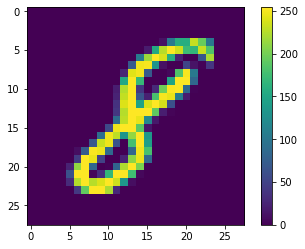

In [5]:
image_index = 7777 # You may select anything up to 60,000
print("\nImage Index:", y_train[image_index]) # The label is 8

# Display image and pixel info
plt.figure()
plt.imshow(x_train[image_index])
plt.colorbar()
plt.show()

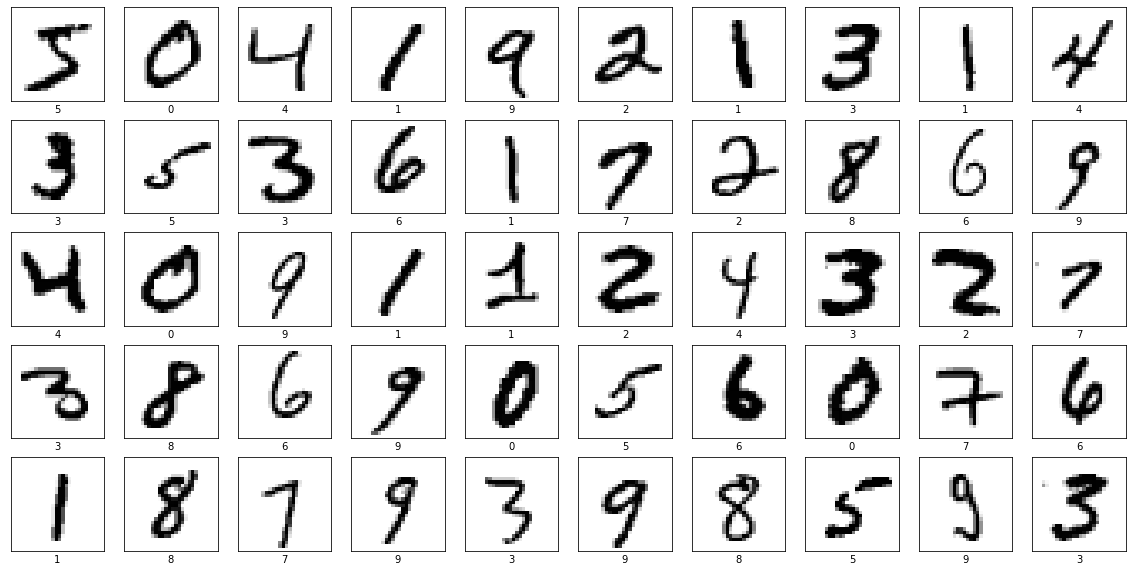

In [6]:
# Verify and inspect training dataset.
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Prepare dataset

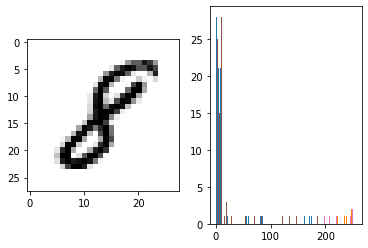

In [7]:
# Sanity Check
pixel_info = np.asarray(x_train[image_index], np.uint8)

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(x_train[image_index], cmap=plt.cm.binary)
ax2.hist(pixel_info, bins=20, range=[0,255])
plt.show()

In [8]:
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255.0
x_test /= 255.0

In [10]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [11]:
print('Training Dataset Shape:', x_train.shape)
print('Number of training images:', x_train.shape[0])
print("Number of training labels:", (len(y_train)))
print('Number of test images:', x_test.shape[0])
print("Number of test labels:", (len(y_test)))

Training Dataset Shape: (60000, 28, 28, 1)
Number of training images: 60000
Number of training labels: 60000
Number of test images: 10000
Number of test labels: 10000


## Create the classification model

In [12]:
# Define the layers of the neural network. Layers extract representations of the data feed into them.
def build_model():
    model = tf.keras.Sequential()
            
    model.add(tf.keras.layers.Conv2D(32, kernel_size=5, activation='relu', input_shape=(28, 28, 1))) #Convolutional layer to identify features from input
    model.add(tf.keras.layers.MaxPooling2D((2,2))) #Choose the best features via pooling
    model.add(tf.keras.layers.BatchNormalization()) #Normalize the batch to help reduce overfitting during training
    model.add(tf.keras.layers.Dropout(0.2)) #Randomly turn neurons on and off to improve convergence
        
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, activation='relu')) #Repeat at 64
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
      
    # A fully connected layer to get all relevant data with rectified linear unit activation, previously was Dense(128) after Flatten().
    model.add(tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # Flatten since too many dimensions, we only want a classification output
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
        
    model.add(tf.keras.layers.Dense(10)) # Value of 10 because of number class 0 to 9.

    # Compile the model and define loss function, optimizer and metrics.
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 64)          2

## Train the model

In [14]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a callback that saves epoch weights during training.
checkpoint_path = "saved_models/" + timestamp + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [15]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
              filepath=checkpoint_path, 
              save_weights_only=True,
              monitor='val_loss',
              save_best_only=True, 
              verbose=0)

# Decrease the learning rate each epoch.
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

# Write logs to .csv
csv_log = tf.keras.callbacks.CSVLogger("./saved_models/" + timestamp + ".log", separator=",", append=True)

In [16]:
# Create a larger dataset by using data augmentation.
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=10,  
          zoom_range = 0.10,  
          width_shift_range=0.1, 
          height_shift_range=0.1)

In [17]:
# Train the model over a number of epochs with callback and batch size.
epochs = 20
batch_size = 64

model_log = model.fit(datagen.flow(x=x_train, y=y_train, batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch = x_train.shape[0]//batch_size,
                      validation_data=(x_test, y_test),
                      verbose=1,
                      callbacks=[annealer, cp_callback, csv_log])

  ...
    to  
  ['...']
Train for 937 steps, validate on 10000 samples
Epoch 1/20
937/937 [==============================] - 29s 31ms/step - loss: 0.3022 - accuracy: 0.9068 - val_loss: 0.0327 - val_accuracy: 0.9896
Epoch 2/20
937/937 [==============================] - 27s 28ms/step - loss: 0.1174 - accuracy: 0.9636 - val_loss: 0.0257 - val_accuracy: 0.9921
Epoch 3/20
937/937 [==============================] - 27s 29ms/step - loss: 0.0918 - accuracy: 0.9715 - val_loss: 0.0216 - val_accuracy: 0.9924
Epoch 4/20
937/937 [==============================] - 27s 28ms/step - loss: 0.0765 - accuracy: 0.9766 - val_loss: 0.0236 - val_accuracy: 0.9922
Epoch 5/20
937/937 [==============================] - 26s 27ms/step - loss: 0.0690 - accuracy: 0.9794 - val_loss: 0.0212 - val_accuracy: 0.9942
Epoch 6/20
937/937 [==============================] - 26s 27ms/step - loss: 0.0652 - accuracy: 0.9799 - val_loss: 0.0380 - val_accuracy: 0.9877
Epoch 7/20
937/937 [==============================] - 25s 27ms/s

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('Test accuracy: {:5.2f}%'.format(100*test_acc))
print('Test loss:', test_loss)

10000/10000 - 1s - loss: 0.0179 - accuracy: 0.9947
Test accuracy: 99.47%
Test loss: 0.01794512018891546


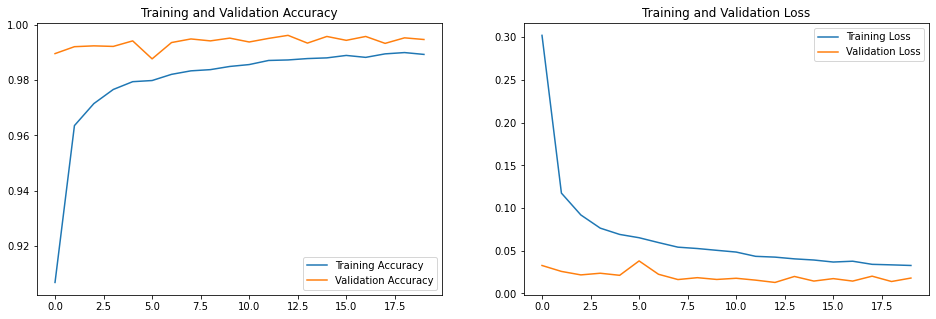

In [19]:
# Visualise training results
acc = model_log.history['accuracy']
val_acc = model_log.history['val_accuracy']

loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Validate training and callbacks

In [20]:
# Create new untrained model to valiadate callback
model = build_model()
loss, acc = model.evaluate(x_test,  y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

10000/10000 - 1s - loss: 2.2963 - accuracy: 0.1134
Untrained model, accuracy: 11.34%


In [21]:
# Loads the weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

# Re-evaluate the pre-trained model
loss,acc = model.evaluate(x_test,  y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

10000/10000 - 1s - loss: 0.0128 - accuracy: 0.9962
Restored model, accuracy: 99.62%


## Evaluate the model

Make predictions using the model's linear outputs, logits. Attach a softmax layer to convert logits to probabilities.

The model outputs a 10 element vector for each image. The individual values of this vector can be thought of, roughly, as relative probabilities that the image belongs in each class. Thus, we consider the class with the maximum value to be the prediction of the model.

In [22]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

i = 1234

predictions = probability_model.predict(x_test)
print("\nPrediction Array:", predictions[i])
print("Argmax:", np.argmax(predictions[i]))
print("Label Class:", y_test[i])


Prediction Array: [4.2979075e-08 4.7306452e-09 2.7020408e-06 1.6777698e-05 6.6490266e-08
 3.8725884e-06 1.1572857e-06 3.8975698e-09 9.9997377e-01 1.5533379e-06]
Argmax: 8
Label Class: 8


In [23]:
# Generate graph to review full set of class predictions.
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [24]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

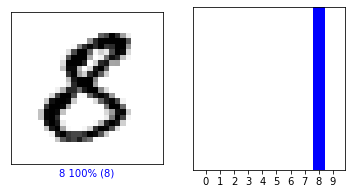

In [25]:
# Verify predictions using plot fuctions.
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test.reshape(x_test.shape[0], 28, 28))
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

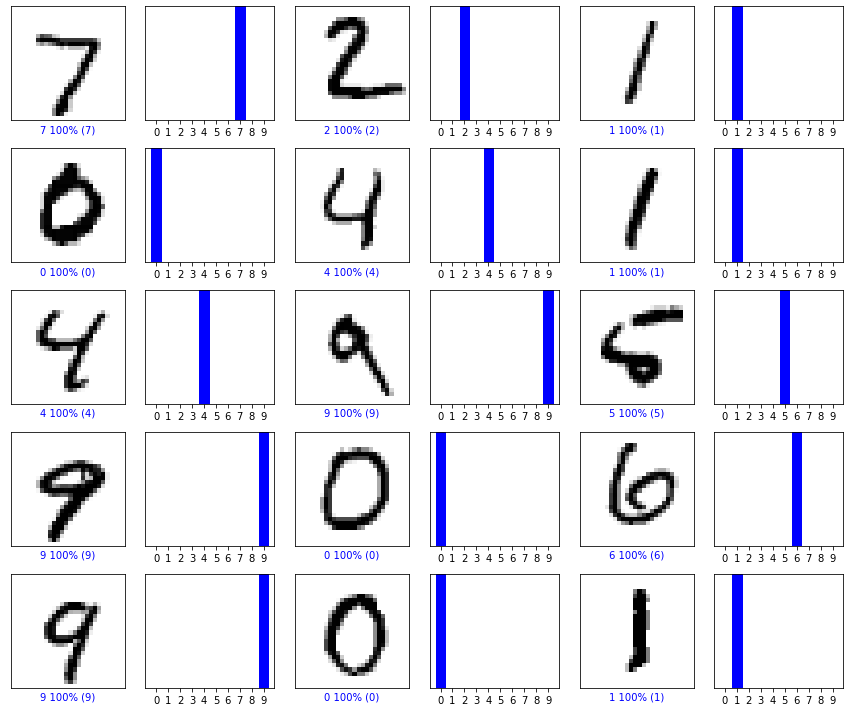

In [26]:
# Plot serveral images as a test array to ensure confidence.
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test.reshape(x_test.shape[0], 28, 28))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

## Confusion Matrix

The rows in the matrix represent the correct classifications, while the columns represent the predictions of the model. When the row and the column agree (i.e., along the diagonal), the model predicted correctly.

In [27]:
confusions = np.zeros([10, 10], np.float32)
bundled = zip(np.argmax(predictions, 1), y_test)

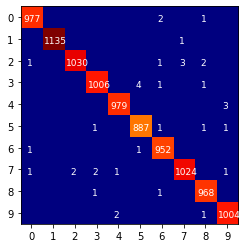

In [28]:
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

Make sure the matrix results roughly matches the distribution of our test set, e.g., it seems like we have fewer '5' values.

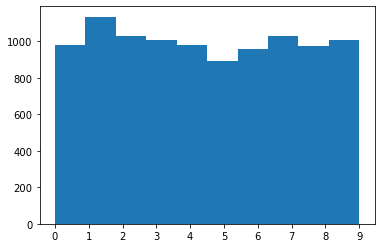

In [29]:
plt.xticks(np.arange(10))
plt.hist(y_test);

Compare the predicted and label classes to compute the error rate.

In [30]:
correct = np.sum(np.argmax(predictions, 1) == y_test)
total = predictions.shape[0]

error = 100.0 - (100 * float(correct) / float(total))

print('Test error: %.1f%%' % error)

Test error: 0.4%


## Exploring feature maps and activation filters

Visualising feature maps and having access to the filters or bias term help show how CNN works internally.

In [31]:
# Display all layers of our model
for layer in model.layers:
    print(str(layer.input))
    print("-------")

Tensor("conv2d_3_input:0", shape=(None, 28, 28, 1), dtype=float32)
-------
Tensor("conv2d_3/Identity:0", shape=(None, 24, 24, 32), dtype=float32)
-------
Tensor("max_pooling2d_2/Identity:0", shape=(None, 12, 12, 32), dtype=float32)
-------
Tensor("batch_normalization_3/Identity:0", shape=(None, 12, 12, 32), dtype=float32)
-------
Tensor("dropout_3/Identity:0", shape=(None, 12, 12, 32), dtype=float32)
-------
Tensor("conv2d_4/Identity:0", shape=(None, 8, 8, 64), dtype=float32)
-------
Tensor("max_pooling2d_3/Identity:0", shape=(None, 4, 4, 64), dtype=float32)
-------
Tensor("batch_normalization_4/Identity:0", shape=(None, 4, 4, 64), dtype=float32)
-------
Tensor("dropout_4/Identity:0", shape=(None, 4, 4, 64), dtype=float32)
-------
Tensor("conv2d_5/Identity:0", shape=(None, 1, 1, 128), dtype=float32)
-------
Tensor("batch_normalization_5/Identity:0", shape=(None, 1, 1, 128), dtype=float32)
-------
Tensor("flatten_1/Identity:0", shape=(None, 128), dtype=float32)
-------
Tensor("dropout_5

A sub-model is required to extract the required layer of feature maps. The output of our new model should be the requried layer of activation.

In [32]:
# Define output layer of sub-model
out = model.layers[3].output  
print(out)

# Create new feature_map model from our trained model
feature_map = tf.keras.Model(inputs = model.inputs, outputs = out)  
feature_map.summary()

Tensor("dropout_3/Identity:0", shape=(None, 12, 12, 32), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
Total params: 960
Trainable params: 896
Non-trainable params: 64
_________________________________________________________________


In [33]:
# Predict input image using feature_map model
fmap=feature_map.predict(x_test[:1])
print(fmap.shape)

(1, 12, 12, 32)


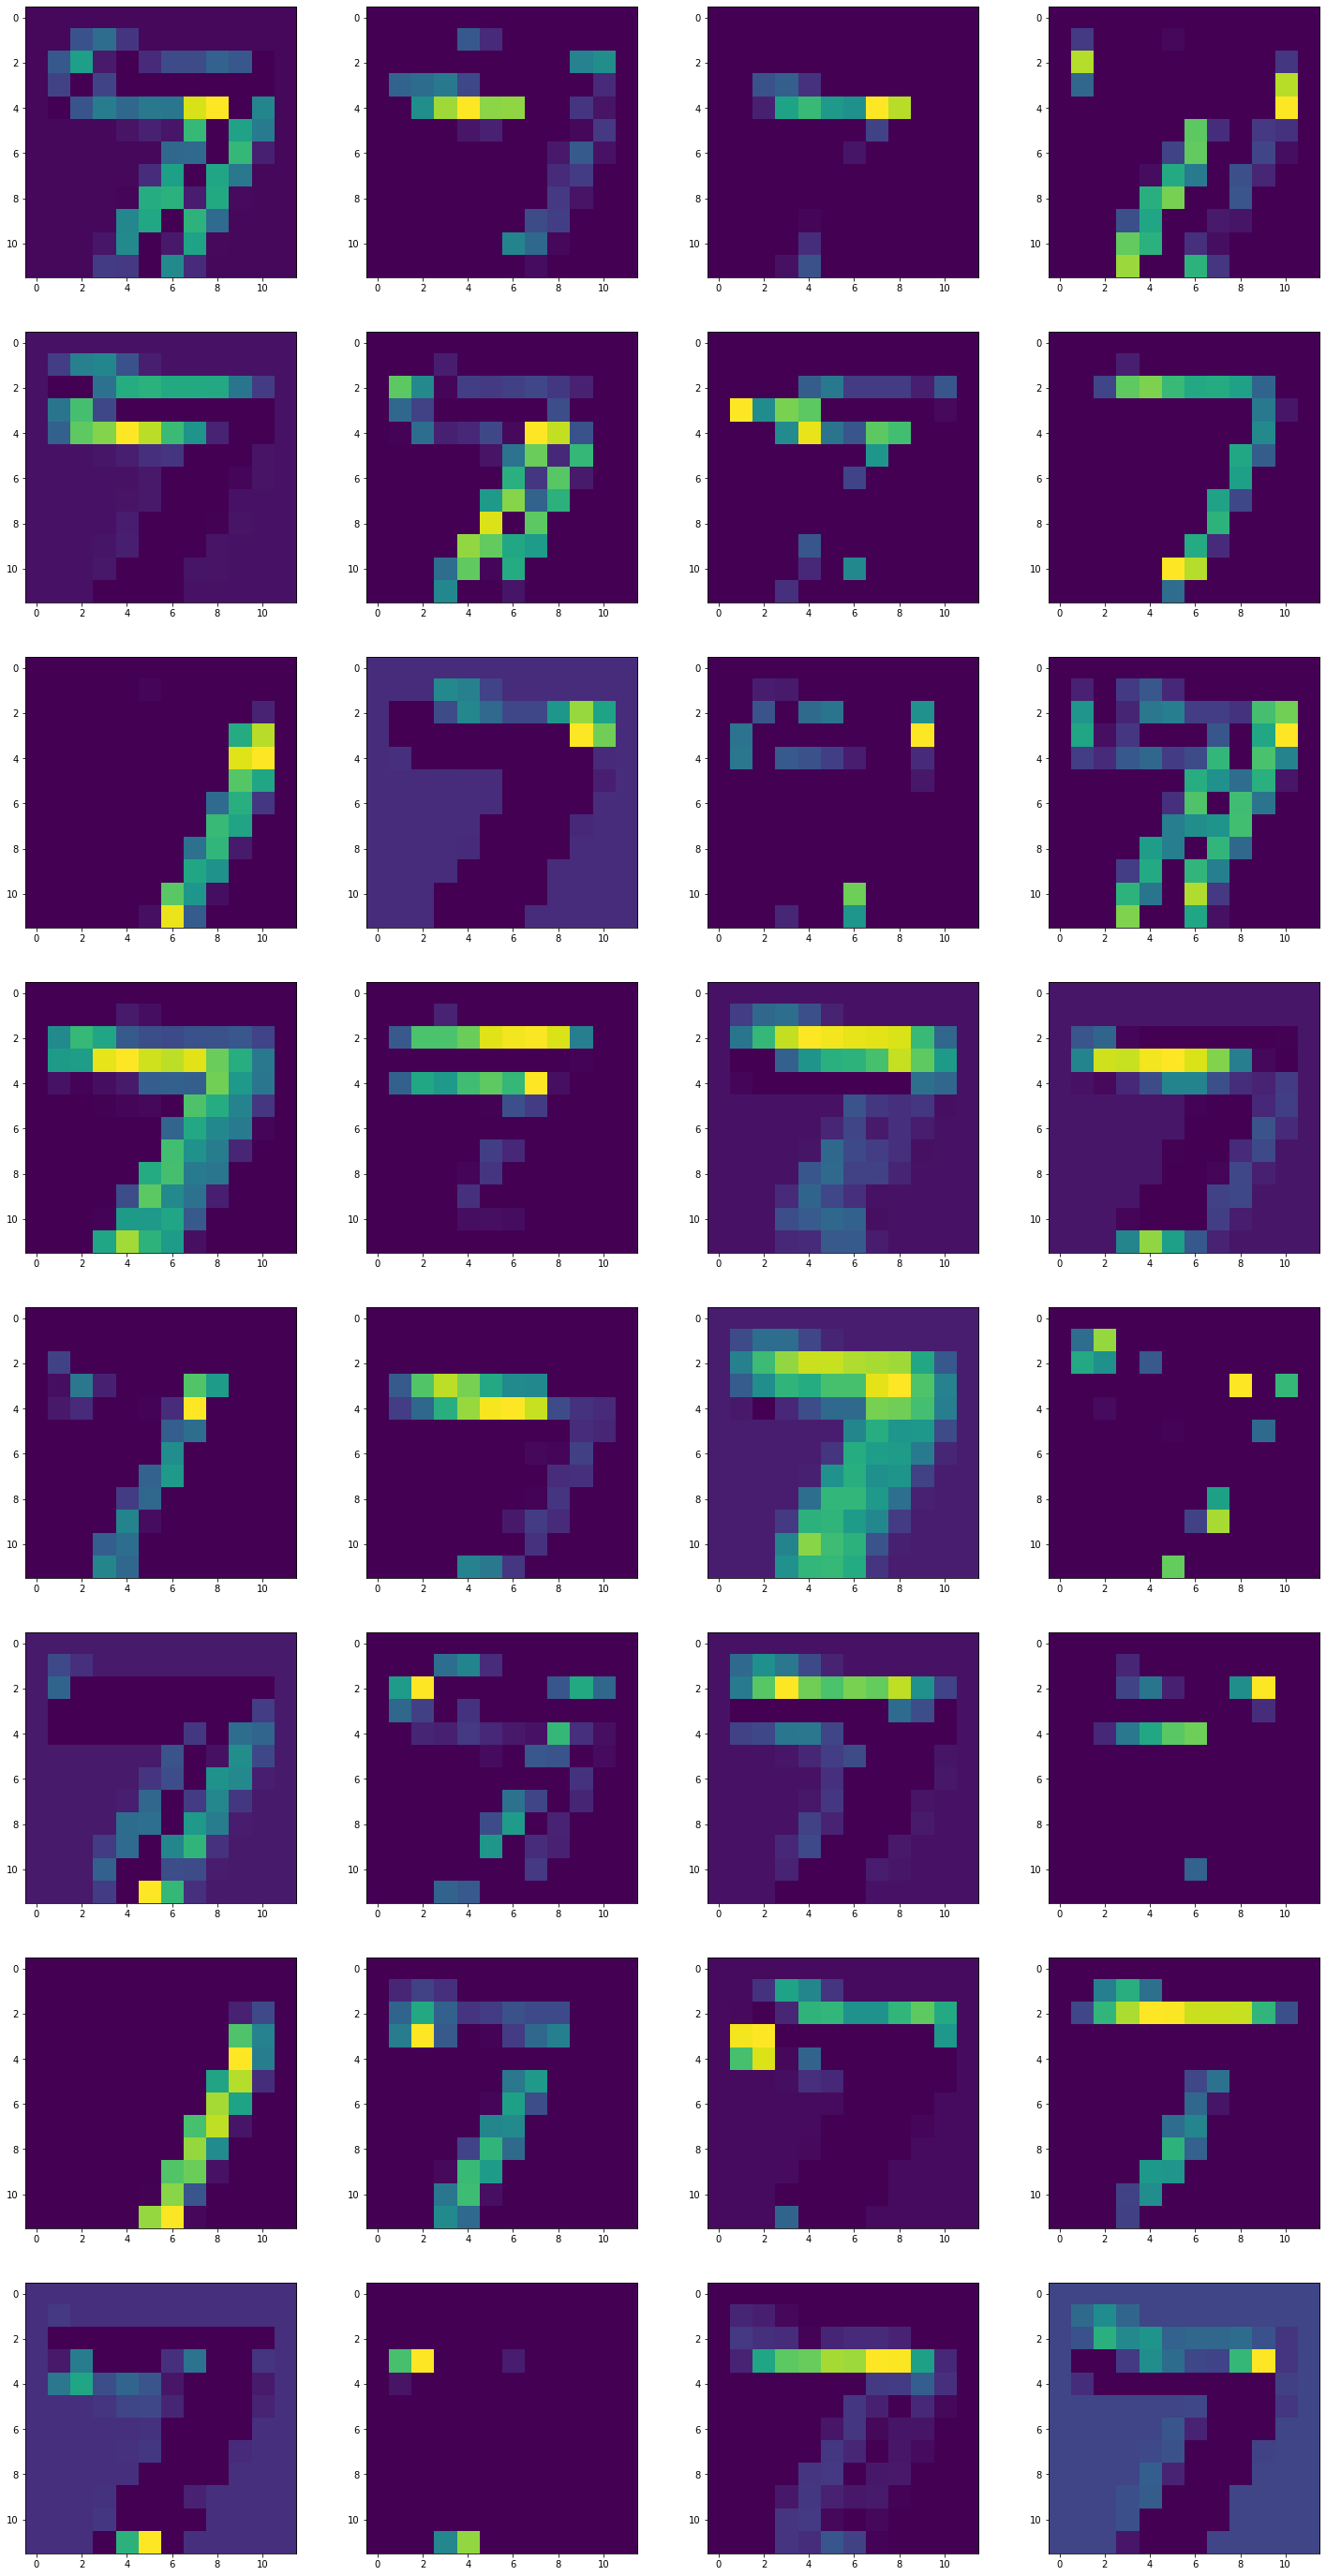

In [34]:
# Display activation features 
fig = plt.figure(figsize=(25,50))

for i in range(32):
    ax=fig.add_subplot(8,4,i+1)
    ax.imshow(fmap[0,:,:,i])

Extract out the filters and bias terms corresponding to every Convolution layer. **get_weights()** is a method that can be applied on the layer instance to get the filters and bias tensors.

In [35]:
# Display only Convolution layers (Filters and Bias belong only to this layer type)
for layer in model.layers:
    if 'conv' in layer.name: 
        filters, bias= layer.get_weights()
        print(layer.name + ' | Filter Shape: ' + str(filters.shape, ) + " " + 'Bias Shape: ' + str(bias.shape))

conv2d_3 | Filter Shape: (5, 5, 1, 32) Bias Shape: (32,)
conv2d_4 | Filter Shape: (5, 5, 32, 64) Bias Shape: (64,)
conv2d_5 | Filter Shape: (4, 4, 64, 128) Bias Shape: (128,)


In [36]:
# Extract filter (kernel) and bias tensors using get_weights()
kernel, bias = model.layers[0].get_weights()
print(kernel.shape, bias.shape)

# Normalize the weights
f_min, f_max = kernel.min(), kernel.max()
kernel = (kernel - f_min) / (f_max - f_min)

(5, 5, 1, 32) (32,)


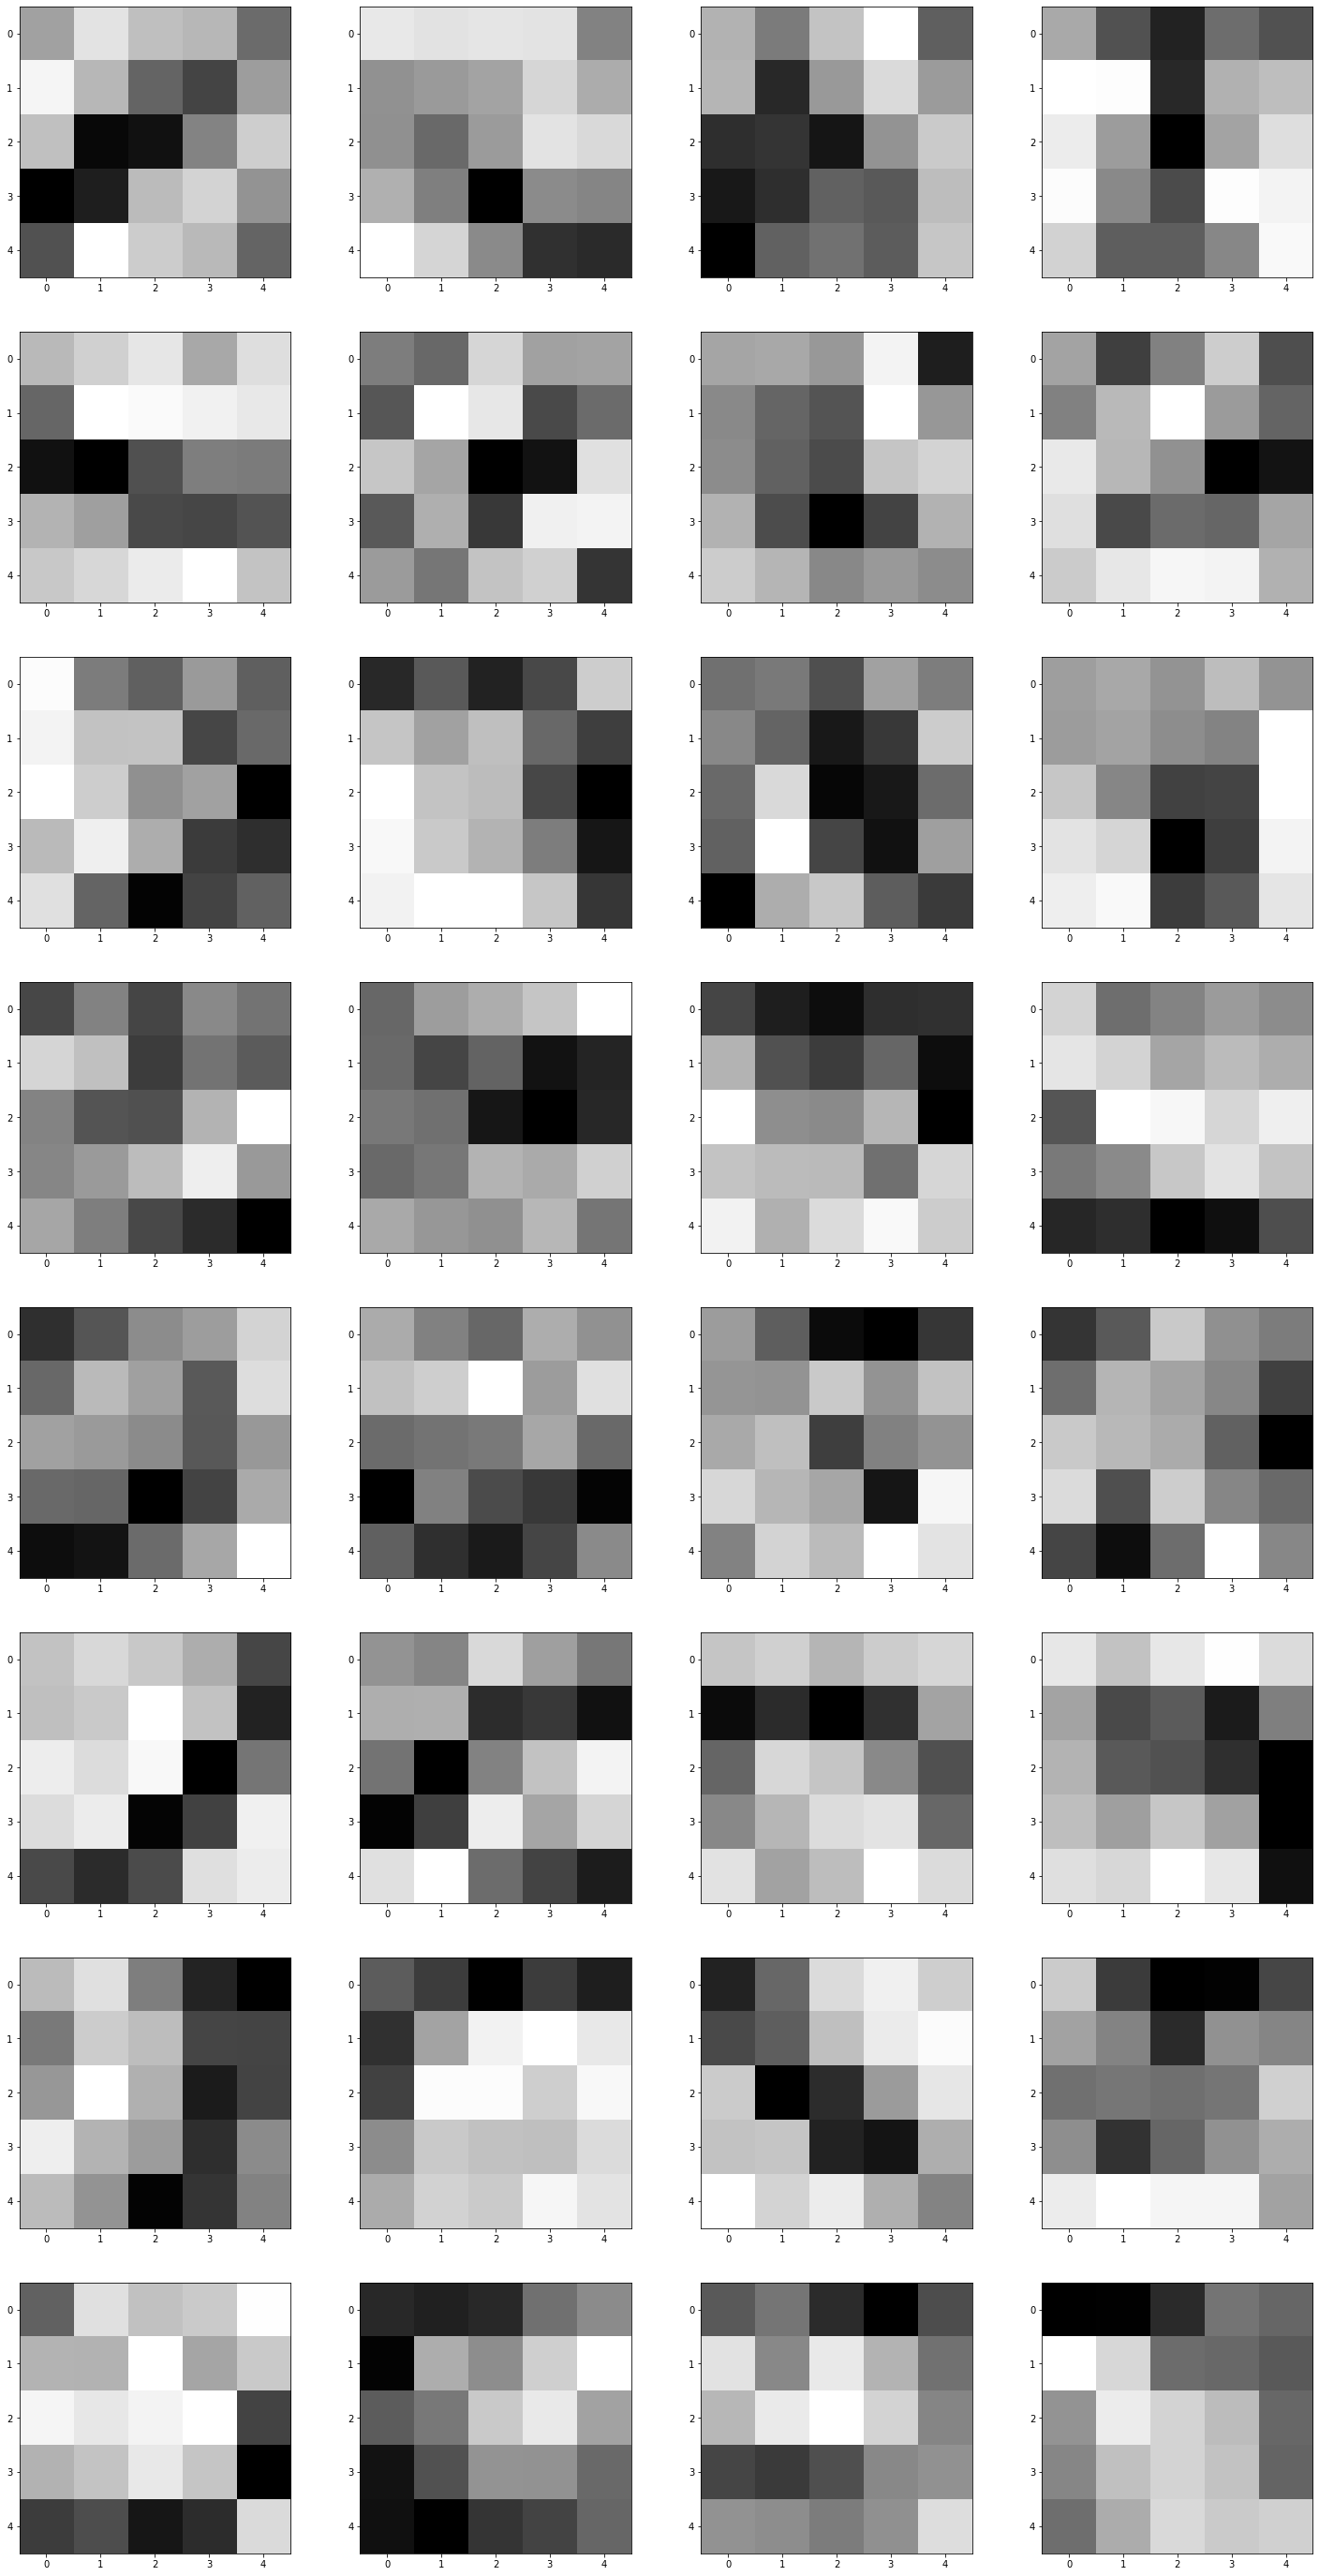

In [37]:
# Display activation filters
fig = plt.figure(figsize=(25,50))

for i in range(32):
    ax = fig.add_subplot(8,4,i+1)
    ax.imshow(kernel[:,:,:,i], cmap='gray')